# Intro to causal forest

This notebook aims to explain how causal forest works and some key differences compared to other well-known tree-based algorithms.

I will also try to apply it to a toy dataset using the implementation of causal forest from EconML. 

## Data generation

Some synthetic data (100,000 samples and 10 covariates) are generated by following a data generation process that is also presented in a [demo notebook](https://github.com/py-why/EconML/blob/main/notebooks/Metalearners%20Examples.ipynb) in EconML. 

**Process**
- $x_i = normal(mean=0, std=1)$
- $Y\_x_i = x_i * uniform(low=-3, high=3) + normal(mean=0, std=1)$
- $TE = 
  \begin{cases}
    8, & \text{if } x_1 > 0.1 \\
    0, & \text{else}
  \end{cases}$
- $propensity = \begin{cases}
    0.8, & \text{if } -0.5 < x_2 <0.5 \\
    0.2, & \text{else}
   \end{cases}$
- $T = binomaial(prop=propensity, trials=1)$
- $Y = TE * T + Y\_x_i$

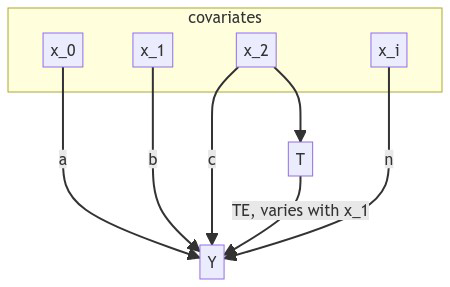

In [1]:
from IPython.display import Image
Image('diagrams/causal_forest/causal_forest.md.1.png')

In [65]:
import numpy as np
import pandas as pd

num_covariates = 10
num_samples = 100000
np.random.seed(42)

df = pd.DataFrame()
for i in range(num_covariates):
  df[f'x{i}'] = np.random.randn(num_samples)  
  df[f'y_x{i}'] = df[f'x{i}'] * np.random.uniform(low=-3, high=3) + np.random.randn(1)

df['TE'] = df['x1'].apply(lambda x: 8 if x>0.1 else 0)
df['propensity'] = df['x2'].apply(lambda x: 0.8 if -0.5<x<0.5 else 0.2)
df['T'] = df['propensity'].apply(lambda x: np.random.binomial(n=1, p=x))
df['Y'] = df['TE'] * df['T'] + df[[col for col in df.columns if 'y_x' in col]].sum(axis=1)

df[[col for col in df.columns if 'y_x' not in col]].describe().transpose().drop(columns='count').drop('propensity')

,mean,std,min,25%,50%,75%,max
x0,0.000967,1.000906,-4.465604,-0.674494,0.002650,0.676915,4.479084
x1,0.003090,1.000497,-4.080833,-0.667894,0.000411,0.672561,4.694473
x2,-0.001496,0.999855,-4.413886,-0.674197,-0.002710,0.672063,4.219366
x3,0.001442,1.002386,-4.301410,-0.675981,0.005557,0.676334,4.293276
x4,-0.006266,1.001158,-4.829436,-0.684352,-0.008103,0.672384,4.301848
x5,-0.001142,1.000885,-4.111276,-0.679754,-0.004396,0.674232,4.295946
x6,0.003354,0.998648,-4.319465,-0.672365,0.008510,0.679251,4.526784
x7,-0.001657,0.998657,-4.386303,-0.676386,0.001485,0.673570,4.329187
x8,-0.003169,1.000302,-3.928834,-0.678930,-0.005792,0.673594,3.980280
x9,-0.002374,0.999370,-4.717265,-0.676115,-0.006132,0.673234,4.276593


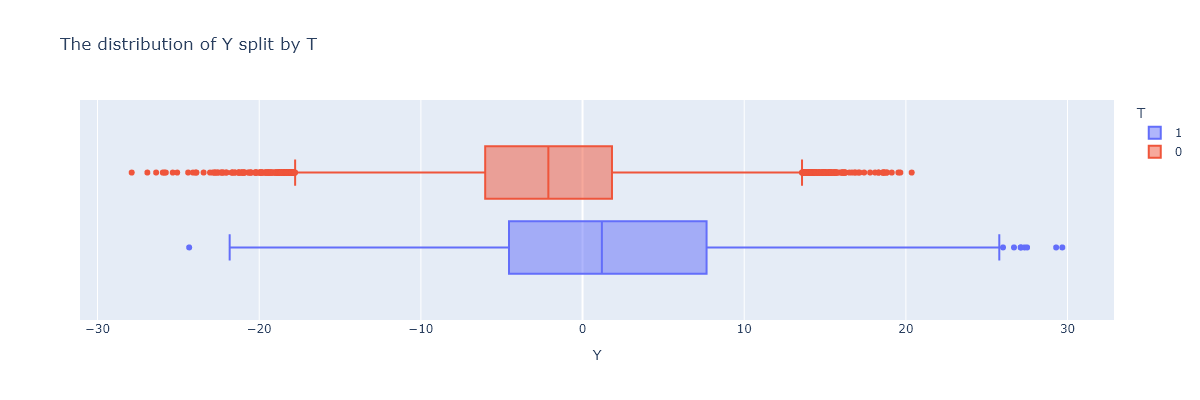

In [69]:
import plotly.express as px
from IPython.display import Image

px.box(df, x='Y', color='T', width=1200, height=400, title='The distribution of Y split by T').write_image('diagrams/causal_forest/Y_dist.png')
Image('diagrams/causal_forest/Y_dist.png')

## Causal forest

Causal forest can estimate heterogeneous treatment effects. It is composed of causal trees, each of which is very similar to the decision tree that we are all familiar with. However, there are several subtle differences, including splitting criteria, evaluation methods, etc. But why can't we use a decision tree to solve uplift modeling problems? The key issue for the decision tree is that it is not designed to estimate treatment effects, and it would introduce generalization bias. Besides, the ground truth is never observed, making it challenging to directly use a decision tree to estimate treatment effects.

### How it works?
Causal forest is a method from generalised random forest. The split criterion of a causal tree is to maximise the average treatment effects between the treated samples and control samples within a leave.



### Learning materials
- [Causal Forest by Susan Athey](https://www.youtube.com/watch?v=oZoizsX3bts&list=PLoazKTcS0RzZ1SUgeOgc6SWt51gfT80N0&index=7)
- [Causa forest intuition](https://www.statworx.com/en/content-hub/blog/machine-learning-goes-causal-ii-meet-the-random-forests-causal-brother/)
- [Causal tree tutorial page 9](https://drive.google.com/drive/u/0/folders/1_h0gepokalfe-dXzoSsS7scc9EE3-DTl)